### Visualize the boundary condition forcing file

In [15]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib
import cmocean
from matplotlib.patches import ConnectionPatch

%matplotlib inline

Plot settings

In [16]:
land_color = '#a9a7a2'

Model dimensions etc.

In [17]:
mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb.nc')
mesh_lon     = np.array(mesh.variables['nav_lon'])
mesh_lat     = np.array(mesh.variables['nav_lat'])
mesh_bathy   = np.array(mesh.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = np.array(mesh.variables['nav_lev'])

In [18]:
imin, imax = 160, 800
jmin, jmax = 1100, 2180

Boundary Condition file:

In [83]:
rimwidthN = 10; rimwidthS = 10; rimwidthE = 20; rimwidthSE = 20; rimwidthW = 10;

In [100]:
BC = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Pb_OBC-20210302.nc', 'r')
dPb_N = np.array(BC.variables['dPb_N']).reshape(50,10,407)
dPb_S = np.array(BC.variables['dPb_S']).reshape(50,10,239)
dPb_E = np.array(BC.variables['dPb_E']).reshape(50,20,579)
dPb_SE = np.array(BC.variables['dPb_SE']).reshape(50,20,35)
dPb_W = np.array(BC.variables['dPb_W']).reshape(50,10,284)

In [101]:
dPb_N_lons = mesh_lon[jmax-rimwidthN:jmax, 392:imax-1] 
dPb_N_lats = mesh_lat[jmax-rimwidthN:jmax, 392:imax-1]
dPb_N_mdepths = bathy_masked[:,jmax-rimwidthN:jmax, 392:imax-1] 

dPb_S_lons = mesh_lon[jmin:jmin+rimwidthS,441:680] 
dPb_S_lats = mesh_lat[jmin:jmin+rimwidthS,441:680]
dPb_S_mdepths = bathy_masked[:,jmin:jmin+rimwidthS,441:680] 

dPb_E_lons = mesh_lon[1601:jmax,imax-1-rimwidthE:imax-1] 
dPb_E_lats = mesh_lat[1601:jmax,imax-1-rimwidthE:imax-1] 
dPb_E_mdepths = bathy_masked[:,1601:jmax,imax-1-rimwidthE:imax-1] 

dPb_SE_lons = mesh_lon[jmin+1:jmin+36,520-rimwidthSE:520] 
dPb_SE_lats = mesh_lat[jmin+1:jmin+36,520-rimwidthSE:520] 
dPb_SE_mdepths = bathy_masked[:,jmin+1:jmin+36,520-rimwidthSE:520] 

dPb_W_lons = mesh_lon[1190:1474,292:292+rimwidthW] 
dPb_W_lats = mesh_lat[1190:1474,292:292+rimwidthW] 
dPb_W_mdepths = bathy_masked[:,1190:1474,292:292+rimwidthW] 

In [102]:
print('Northern boundary dimensions: ', dPb_N.shape, dPb_N_lons.shape, dPb_N_lats.shape, dPb_N_mdepths.shape)
print('Eastern boundary dimensions: ', dPb_E.shape, dPb_E_lons.shape, dPb_E_lats.shape, dPb_E_mdepths.shape)
print('Southern boundary dimensions: ', dPb_S.shape, dPb_S_lons.shape, dPb_S_lats.shape, dPb_S_mdepths.shape)
print('Southeastern boundary dimensions: ', dPb_SE.shape, dPb_SE_lons.shape, dPb_SE_lats.shape, dPb_SE_mdepths.shape)
print('Western boundary dimensions: ', dPb_W.shape, dPb_W_lons.shape, dPb_W_lats.shape, dPb_W_mdepths.shape)

Northern boundary dimensions:  (50, 10, 407) (10, 407) (10, 407) (50, 10, 407)
Eastern boundary dimensions:  (50, 20, 579) (579, 20) (579, 20) (50, 579, 20)
Southern boundary dimensions:  (50, 10, 239) (10, 239) (10, 239) (50, 10, 239)
Southeastern boundary dimensions:  (50, 20, 35) (35, 20) (35, 20) (50, 35, 20)
Western boundary dimensions:  (50, 10, 284) (284, 10) (284, 10) (50, 284, 10)


Pb observations:

In [103]:
folder= '/ocean/brogalla/GEOTRACES/data/'

# North Atlantic
Pb_NA = nc.Dataset(folder+'GEOTRACES_IDP2017_v2_Discrete_Sample_Data_5024209a_1.nc', 'r')
NA_lats   = np.tile(Pb_NA.variables['latitude'], (288,1)).transpose()
NA_lons   = np.tile(Pb_NA.variables['longitude'], (288,1)).transpose()
NA_depths = np.array(Pb_NA.variables['var2'])
Pb_NA     = np.array(Pb_NA.variables['var5']) # in pmol/kg
mNA_Pb     = np.ma.masked_where(np.logical_or( Pb_NA > 1e5, Pb_NA < -1e5), Pb_NA).compressed()
mNA_depths = np.ma.masked_where(np.logical_or( Pb_NA > 1e5, Pb_NA < -1e5), NA_depths).compressed()
mNA_lons   = np.ma.masked_where(np.logical_or( Pb_NA > 1e5, Pb_NA < -1e5), NA_lons).compressed()
mNA_lons[mNA_lons > 180] = mNA_lons[mNA_lons > 180] - 360
mNA_lats   = np.ma.masked_where(np.logical_or( Pb_NA > 1e5, Pb_NA < -1e5), NA_lats).compressed()

# Arctic Ocean (from Rob Rember):
df = pd.read_csv(folder+'Pb_rob_rember.csv', parse_dates=['DATE']).dropna()
AO_depths = np.array(df['CTDDEPTH'])
AO_lats   = np.array(df['LATITUDE'])
AO_lons   = np.array(df['LONGITUDE'])
AO_dPb    = np.array(df['Pb_(pMol)'])

### Figure

In [104]:
def plot_BC(axis, location, xlim=(68, 80), ylim=(4000, -50), vlim=(0,25)):
    # --- axis is the plotting axis
    # --- location is one of "CB", "BB", "AO", or "BBE"
    # --- xlim is coordinate pair of lower and upper limit of x-axis
    # --- ylim is coordinate pair of lower and upper limit of y-axis
    
    axis.invert_yaxis()
    axis.set_xlim([xlim[0], xlim[1]])
    axis.set_ylim([ylim[0], ylim[1]])
    axis.tick_params(axis='both', which='major', labelsize=12)
    
    if location == 'CB': # Western Canada Basin
        dPb = dPb_N[:,-1,:]
        xx, zz = np.meshgrid(dPb_N_lats[-1,:], depths)
        bathy = dPb_N_mdepths[:,-1,:]
    elif location =='AO': #Northern Canada Basin
        dPb = dPb_E[:,-1,:]
        xx, zz = np.meshgrid(-1*dPb_E_lons[:,-1], depths)
        bathy = dPb_E_mdepths[:,:,-1]
    elif location == 'BB': # Labrador Sea
        dPb = dPb_S[:,-1,:]
        xx, zz = np.meshgrid(-1*dPb_S_lons[-1,:], depths)
        bathy = dPb_S_mdepths[:,-1,:]
    elif location == 'BBE': # Tip of Greenland
        dPb = dPb_SE[:,-1,:]
        xx, zz = np.meshgrid(dPb_SE_lats[:,-1], depths)
        bathy = dPb_SE_mdepths[:,:,-1]
    elif location == 'HB': # Hudson Bay
        dPb = dPb_W[:,-1,:]
        xx, zz = np.meshgrid(-1*dPb_W_lons[:,-1], depths)
        bathy = dPb_W_mdepths[:,:,-1]

    # Plot boundary condition:    
    if location == 'CB' or location == 'AO':
        CB = axis.pcolor(xx, zz, dPb*1e12, vmin=vlim[0], vmax=vlim[1], cmap=cmocean.cm.deep_r)
    else:
        CB = axis.pcolor(xx, zz, dPb*1e12, vmin=vlim[0], vmax=vlim[1], cmap=cmocean.cm.matter_r)
    axis.contourf(xx, zz, bathy, cmap=matplotlib.colors.ListedColormap([land_color]))
        
    # superimpose observations:
    if location == 'CB':
        axis.scatter(AO_lats[(AO_lats > 71) & (AO_lats < 75) & (AO_lons < -150)], \
                     AO_depths[(AO_lats > 71) & (AO_lats < 75) & (AO_lons < -150)],\
                     c=AO_dPb[(AO_lats > 71) & (AO_lats < 75) & (AO_lons < -150)], \
                     vmin=vmin_CS1, vmax=vmax_CS1, edgecolor='w', cmap=cmocean.cm.deep_r, s=100)
    elif location == 'AO':
        axis.scatter(-1*AO_lons[(AO_lats > 80) & (AO_lons > -150)], \
                     AO_depths[(AO_lats > 80) & (AO_lons > -150)], \
                     c =AO_dPb[(AO_lats > 80) & (AO_lons > -150)], \
                     vmin = vmin_CS1, vmax = vmax_CS1, edgecolor='w', cmap=cmocean.cm.deep_r, s=100)
        axis.scatter(-1*AO_lons[(AO_lats > 75) & (AO_lons < -150) & (AO_lons > -179)], \
                     AO_depths[(AO_lats > 75) & (AO_lons < -150) & (AO_lons > -179)], \
                     c =AO_dPb[(AO_lats > 75) & (AO_lons < -150) & (AO_lons > -179)], \
                     vmin = vmin_CS1, vmax = vmax_CS1, edgecolor='w', cmap=cmocean.cm.deep_r, s=100)
    elif location == 'BB':
        axis.scatter(-1*mNA_lons[(mNA_lats < 60) & (mNA_lats > 52) & (mNA_lons > -90) & (mNA_lons <-44)], \
                     mNA_depths[(mNA_lats < 60) & (mNA_lats > 52) & (mNA_lons > -90) & (mNA_lons <-44)], \
                     c=mNA_Pb[(mNA_lats < 60) & (mNA_lats > 52) & (mNA_lons > -90) & (mNA_lons <-44)], \
                     vmin=vmin_CS2, vmax=vmax_CS2, edgecolor='w', cmap=cmocean.cm.matter_r, s=100)
    elif location == 'BBE':
        axis.scatter(mNA_lats[(mNA_lats < 64) & (mNA_lats > 55) & (mNA_lons > -44) & (mNA_lons <-39)], \
                     mNA_depths[(mNA_lats < 64) & (mNA_lats > 55) & (mNA_lons > -44) & (mNA_lons <-39)], \
                     c=mNA_Pb[(mNA_lats < 64) & (mNA_lats > 55) & (mNA_lons > -44) & (mNA_lons <-39)], \
                     vmin=vmin_CS2, vmax=vmax_CS2, edgecolor='w', cmap=cmocean.cm.matter_r, s=100) 
    
    return CB

In [105]:
color_sBB = '#0873B4'
color_sGR = '#ff9966'
color_wCB = '#0873B4'
color_nCB = '#ff9966'
color_wHB = '#ff9966'

In [106]:
boundary_names = ['Northern Canada Basin', 'Western Canada Basin', 'Hudson Bay', 'Labrador Sea', 'Tip of Greenland']

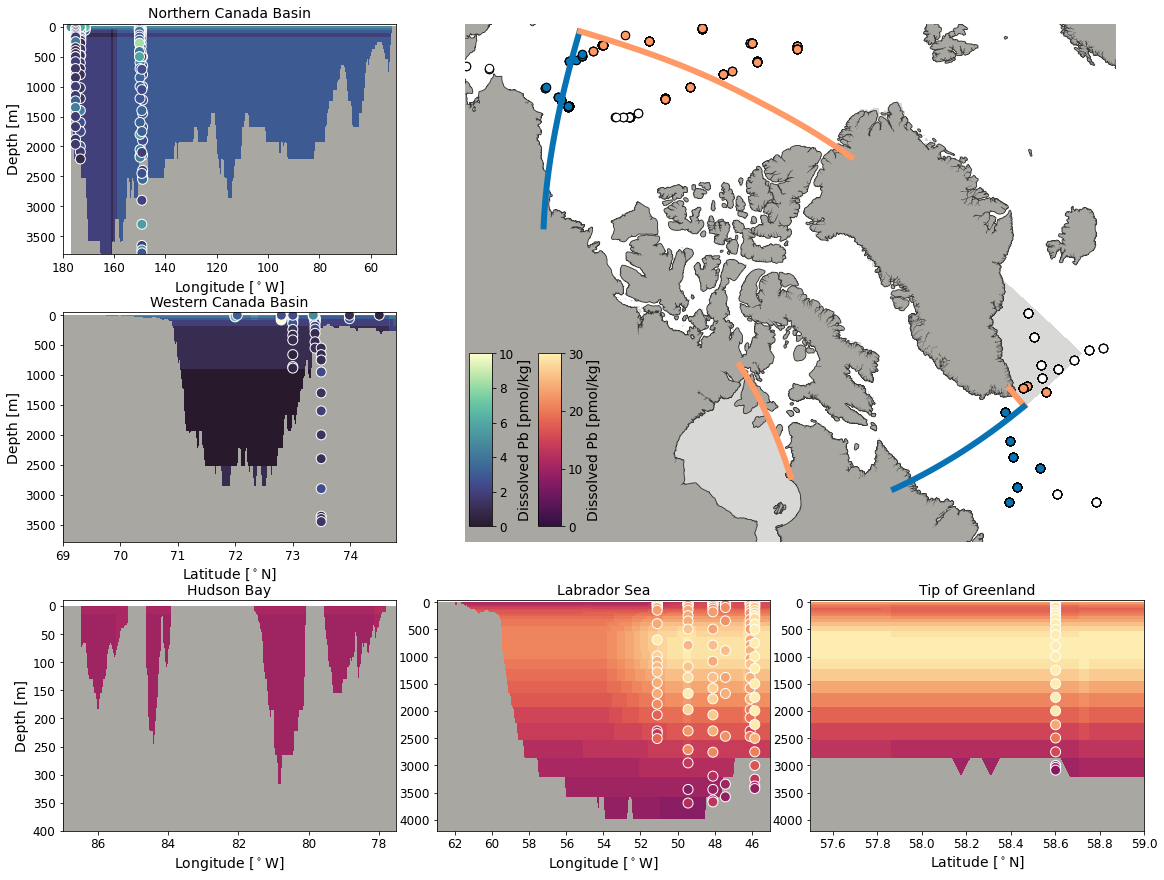

In [107]:
fig = plt.figure(figsize=(16,12))
ax1 = plt.subplot2grid((3, 3), (0, 1), rowspan=2, colspan=2) # map
ax2 = plt.subplot2grid((3, 3), (0, 0)) # left upper
ax3 = plt.subplot2grid((3, 3), (1, 0)) # left middle
ax4 = plt.subplot2grid((3, 3), (2, 0)) # left bottom
ax5 = plt.subplot2grid((3, 3), (2, 1)) # bottom middle
ax6 = plt.subplot2grid((3, 3), (2, 2)) # bottom right

axes = [ax2, ax3, ax4, ax5, ax6]

# ----------- Map ------------------------------------------------
proj=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax1)
proj.drawcoastlines(color='#373736', linewidth=1.8)
proj.fillcontinents(color=land_color, lake_color=land_color, zorder=5)
ax1.set_frame_on(False)
x, y = proj(mesh_lon, mesh_lat)
proj.contourf(x, y, bathy_masked[0,:,:], colors=['#d8d8d6']) # land mask

# Domain boundaries: 
proj.plot(x[jmin:1136,680]   , y[jmin:1136,680]    , '-', c=color_sGR, lw=6, zorder=5); # southeastern Greenland
proj.plot(x[jmin,442:680]    , y[jmin,442:680]     , '-', c=color_sBB, lw=6, zorder=5); # southern Baffin Bay
proj.plot(x[jmax,392:imax-1] , y[jmax,392:imax-1]  , '-', c=color_wCB, lw=6, zorder=5); # western Canada Basin
proj.plot(x[1600:jmax,imax-1], y[1600:jmax,imax-1] , '-', c=color_nCB, lw=6, zorder=5); # northern Canada Basin
proj.plot(x[1190:1474,292]   , y[1190:1474,292]    , '-', c=color_wHB, lw=6, zorder=5); # Hudson Bay bdy

# Label station locations on map: Arctic Ocean
x_AO, y_AO = proj(AO_lons , AO_lats) 
proj.scatter(x_AO, y_AO, c='w', s=70, zorder=5, edgecolor='k')
proj.scatter(x_AO[(AO_lats > 80) & (AO_lons > -150)], \
             y_AO[(AO_lats > 80) & (AO_lons > -150)], \
             c=color_nCB, s=70, zorder=5, edgecolor='k')
proj.scatter(x_AO[(AO_lats > 75) & (AO_lons < -150) & (AO_lons > -179)], \
             y_AO[(AO_lats > 75) & (AO_lons < -150) & (AO_lons > -179)], \
             c=color_nCB, s=70, zorder=5, edgecolor='k')
proj.scatter(x_AO[(AO_lats > 71) & (AO_lats < 75) & (AO_lons < -150)], \
             y_AO[(AO_lats > 71) & (AO_lats < 75) & (AO_lons < -150)], \
             c=color_wCB, s=70, zorder=5, edgecolor='k')

# Label station locations on map: North Atlantic
x_NA, y_NA = proj(mNA_lons, mNA_lats) 
proj.scatter(x_NA, y_NA, c='w', s=70, zorder=5, edgecolor='k')
proj.scatter(x_NA[(mNA_lats < 60) & (mNA_lats > 52) & (mNA_lons > -90) & (mNA_lons <-44)], \
             y_NA[(mNA_lats < 60) & (mNA_lats > 52) & (mNA_lons > -90) & (mNA_lons <-44)], \
             c=color_sBB, s=70, zorder=5, edgecolor='k')
proj.scatter(x_NA[(mNA_lats < 64) & (mNA_lats > 55) & (mNA_lons > -44) & (mNA_lons <-39)], \
             y_NA[(mNA_lats < 64) & (mNA_lats > 55) & (mNA_lons > -44) & (mNA_lons <-39)], \
             c=color_sGR, s=70, zorder=5, edgecolor='k')

# -----------  Boundary Condition subplots: ----------- 
# titles:
for ind, ax in enumerate(axes):
    ax.set_title(boundary_names[ind], fontsize=14)
    if ind < 3:
        ax.set_ylabel('Depth [m]', fontsize=14)
    if (ind == 1) or (ind == 4):
        ax.set_xlabel('Latitude [$^\circ$N]', fontsize=14)
    else:
        ax.set_xlabel('Longitude [$^\circ$W]', fontsize=14) 

vmin_CS1 = 0; vmax_CS1 = 10;
vmin_CS2 = 0; vmax_CS2 = 30;
CS1 = plot_BC(ax2, 'AO' , xlim=(180,50) , ylim=(3800,-50), vlim=(vmin_CS1, vmax_CS1))
CS1 = plot_BC(ax3, 'CB' , xlim=(69,74.8)  , ylim=(3800,-50), vlim=(vmin_CS1, vmax_CS1))
CS2 = plot_BC(ax4, 'HB' , xlim=(87,77.5)  , ylim=(400,-10), vlim=(vmin_CS2, vmax_CS2))
CS2 = plot_BC(ax5, 'BB' , xlim=(63,45)  , ylim=(4200,-30), vlim=(vmin_CS2, vmax_CS2))
CS2 = plot_BC(ax6, 'BBE', xlim=(57.5,59), ylim=(4200,-30), vlim=(vmin_CS2, vmax_CS2))
# CS1 = plot_BC(ax2, 'AO' , xlim=(180,50) , ylim=(500,-50), vlim=(vmin_CS1, vmax_CS1))
# CS1 = plot_BC(ax3, 'CB' , xlim=(69,74.8)  , ylim=(500,-50), vlim=(vmin_CS1, vmax_CS1))
# CS2 = plot_BC(ax4, 'HB' , xlim=(87,77.5)  , ylim=(400,-10), vlim=(vmin_CS2, vmax_CS2))
# CS2 = plot_BC(ax5, 'BB' , xlim=(63,45)  , ylim=(500,-30), vlim=(vmin_CS2, vmax_CS2))
# CS2 = plot_BC(ax6, 'BBE', xlim=(57.5,59), ylim=(500,-30), vlim=(vmin_CS2, vmax_CS2))


# ---------- Settings: --------------------------------
plt.tight_layout(pad=-0.1, w_pad=-0.5, h_pad=-0.1)

cbaxes1 = fig.add_axes([0.40, 0.40, 0.02, 0.2]) 
cbaxes2 = fig.add_axes([0.46, 0.40, 0.02, 0.2]) 
CBar1 = plt.colorbar(CS1, ax=ax1, cax=cbaxes1, orientation='vertical', ticks=[0,2,4,6,8,10,12,14,16])
CBar2 = plt.colorbar(CS2, ax=ax2, cax=cbaxes2, orientation='vertical', ticks=[0,10,20,30,40])
CBar1.ax.tick_params(labelsize=12) 
CBar2.ax.tick_params(labelsize=12) 
CBar1.set_label('Dissolved Pb [pmol/kg]', fontsize=14)
CBar2.set_label('Dissolved Pb [pmol/kg]', fontsize=14)